In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon Jan 15 19:11:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.mol_conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.006843566894531
encoder.convs 5.9912109375
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.1512603759765625
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.1457672119140625
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.15-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 374252
-rw-rw-r-- 1 scpark scpark        40  1월 15 19:11 events.out.tfevents.1705313240.GPUSVR01
-rw-rw-r-- 1 scpark scpark      2100  1월 15 19:11 events.out.tfevents.1705313358.GPUSVR01
-rw-rw-r-- 1 scpark scpark       130  1월 15 19:11 events.out.tfevents.1705313508.GPUSVR01
-rw-rw-r-- 1 scpark scpark 383219871  1월 15 19:11 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = torch.tile(x, (1, 3, 1, 1)).to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


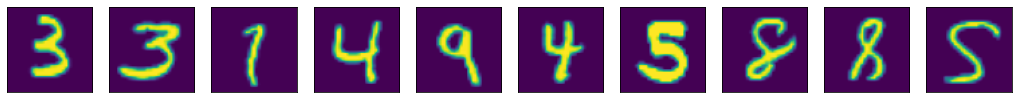

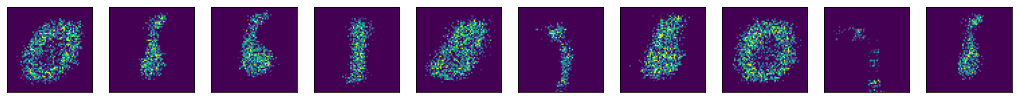

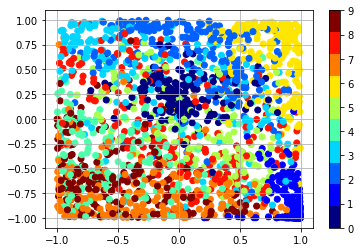

3001
lse_loss 0.005911264568567276
recon_loss 0.6923611760139465
3002
lse_loss 0.0054878718219697475
recon_loss 0.7701423764228821
3003
lse_loss 0.005765114910900593
recon_loss 0.7209372520446777
3004
lse_loss 0.005490265786647797
recon_loss 0.7209119200706482
3005
lse_loss 0.005194155033677816
recon_loss 0.711401641368866
3006
lse_loss 0.005190176889300346
recon_loss 0.6870218515396118
3007
lse_loss 0.00569606339558959
recon_loss 0.7202960252761841
3008
lse_loss 0.005323696881532669
recon_loss 0.6829397678375244
3009
lse_loss 0.005369589664041996
recon_loss 0.7128489017486572
3010
lse_loss 0.0060033537447452545
recon_loss 0.6775240302085876
3011
lse_loss 0.005751228891313076
recon_loss 0.6825166940689087
3012
lse_loss 0.005110493861138821
recon_loss 0.6829664707183838
3013
lse_loss 0.0055921198800206184
recon_loss 0.6588894724845886
3014
lse_loss 0.006167764775454998
recon_loss 0.6892461776733398
3015
lse_loss 0.005753641482442617
recon_loss 0.6455308794975281
3016
lse_loss 0.00615857

3128
lse_loss 0.005746348761022091
recon_loss 1.258937954902649
3129
lse_loss 0.006279726512730122
recon_loss 1.2382636070251465
3130
lse_loss 0.005869648419320583
recon_loss 1.1985478401184082
3131
lse_loss 0.00617580208927393
recon_loss 1.1763007640838623
3132
lse_loss 0.00610672403126955
recon_loss 1.1755826473236084
3133
lse_loss 0.00575562147423625
recon_loss 1.1441457271575928
3134
lse_loss 0.0054101040586829185
recon_loss 1.1281272172927856
3135
lse_loss 0.005137241445481777
recon_loss 1.088897705078125
3136
lse_loss 0.006116717122495174
recon_loss 1.062963604927063
3137
lse_loss 0.006103341467678547
recon_loss 1.0577809810638428
3138
lse_loss 0.00658990815281868
recon_loss 1.0105605125427246
3139
lse_loss 0.006011961959302425
recon_loss 1.0274041891098022
3140
lse_loss 0.005731948651373386
recon_loss 0.9368557333946228
3141
lse_loss 0.0060800351202487946
recon_loss 1.0122878551483154
3142
lse_loss 0.006215143948793411
recon_loss 1.014038324356079
3143
lse_loss 0.005792803131043

lse_loss 0.006777381058782339
recon_loss 0.6759511232376099
3256
lse_loss 0.0066236467100679874
recon_loss 0.7421284317970276
3257
lse_loss 0.00621418422088027
recon_loss 0.7384476065635681
3258
lse_loss 0.006930309347808361
recon_loss 0.6667013168334961
3259
lse_loss 0.006417799741029739
recon_loss 0.7619403004646301
3260
lse_loss 0.007431138306856155
recon_loss 0.6888635158538818
3261
lse_loss 0.005881607532501221
recon_loss 0.6932159066200256
3262
lse_loss 0.00690200412645936
recon_loss 0.8000328540802002
3263
lse_loss 0.0059984405525028706
recon_loss 0.7984327077865601
3264
lse_loss 0.006330213043838739
recon_loss 0.7881766557693481
3265
lse_loss 0.00645257905125618
recon_loss 0.7101064324378967
3266
lse_loss 0.006956452503800392
recon_loss 0.847914457321167
3267
lse_loss 0.007367266342043877
recon_loss 0.7813971638679504
3268
lse_loss 0.006175784394145012
recon_loss 0.7561936378479004
3269
lse_loss 0.006398066412657499
recon_loss 0.7919255495071411
3270
lse_loss 0.0060589909553527

3382
lse_loss 0.005589569918811321
recon_loss 0.8384503126144409
3383
lse_loss 0.0060108802281320095
recon_loss 0.7792004942893982
3384
lse_loss 0.006607799790799618
recon_loss 0.8447206616401672
3385
lse_loss 0.00552814407274127
recon_loss 0.7455129027366638
3386
lse_loss 0.0056020100601017475
recon_loss 0.7074040174484253
3387
lse_loss 0.00706119230017066
recon_loss 0.8492740392684937
3388
lse_loss 0.006427050568163395
recon_loss 0.7246006727218628
3389
lse_loss 0.006805281154811382
recon_loss 0.8745312690734863
3390
lse_loss 0.0063467915169894695
recon_loss 0.727779746055603
3391
lse_loss 0.005877099931240082
recon_loss 0.8212257027626038
3392
lse_loss 0.006884781643748283
recon_loss 0.9142718315124512
3393
lse_loss 0.006967869587242603
recon_loss 0.6754212379455566
3394
lse_loss 0.005588064901530743
recon_loss 0.8617875576019287
3395
lse_loss 0.005688349716365337
recon_loss 0.7156325578689575
3396
lse_loss 0.00678328238427639
recon_loss 0.7979331612586975
3397
lse_loss 0.0057998094

lse_loss 0.00574166513979435
recon_loss 0.9188210964202881
3510
lse_loss 0.005287457257509232
recon_loss 0.9357965588569641
3511
lse_loss 0.006134486757218838
recon_loss 0.8943394422531128
3512
lse_loss 0.00516501534730196
recon_loss 0.853558361530304
3513
lse_loss 0.005714803002774715
recon_loss 0.935689389705658
3514
lse_loss 0.006100122816860676
recon_loss 0.9091392755508423
3515
lse_loss 0.006217652000486851
recon_loss 0.8601559400558472
3516
lse_loss 0.005766705144196749
recon_loss 0.9815016984939575
3517
lse_loss 0.00622936338186264
recon_loss 0.8145320415496826
3518
lse_loss 0.006671522278338671
recon_loss 0.8580676913261414
3519
lse_loss 0.0070428913459181786
recon_loss 0.8178741931915283
3520
lse_loss 0.005714314058423042
recon_loss 0.8539689779281616
3521
lse_loss 0.006320579443126917
recon_loss 0.7948613166809082
3522
lse_loss 0.006647540256381035
recon_loss 0.8819926977157593
3523
lse_loss 0.005607209168374538
recon_loss 0.8120103478431702
3524
lse_loss 0.01712934672832489


3636
lse_loss 0.005681298673152924
recon_loss 0.7345137596130371
3637
lse_loss 0.005566641688346863
recon_loss 0.697290301322937
3638
lse_loss 0.00623671431094408
recon_loss 0.7306694388389587
3639
lse_loss 0.005475079640746117
recon_loss 0.7301206588745117
3640
lse_loss 0.006403299979865551
recon_loss 0.7152167558670044
3641
lse_loss 0.006002054084092379
recon_loss 0.7084603309631348
3642
lse_loss 0.006652244366705418
recon_loss 0.7263139486312866
3643
lse_loss 0.006629345007240772
recon_loss 0.708615779876709
3644
lse_loss 0.006660164799541235
recon_loss 0.6682583689689636
3645
lse_loss 0.005126778967678547
recon_loss 0.6949511170387268
3646
lse_loss 0.005308411084115505
recon_loss 0.7034701704978943
3647
lse_loss 0.005817939527332783
recon_loss 0.6761493682861328
3648
lse_loss 0.005754509009420872
recon_loss 0.6770232319831848
3649
lse_loss 0.005842607002705336
recon_loss 0.666789710521698
3650
lse_loss 0.0057869222946465015
recon_loss 0.6828914284706116
3651
lse_loss 0.006632455158

lse_loss 0.007403745781630278
recon_loss 0.8307290077209473
3764
lse_loss 0.0062865642830729485
recon_loss 0.8163293600082397
3765
lse_loss 0.006365607958287001
recon_loss 0.8019089102745056
3766
lse_loss 0.007063108496367931
recon_loss 0.8183982968330383
3767
lse_loss 0.006311591248959303
recon_loss 0.7765478491783142
3768
lse_loss 0.006400357466191053
recon_loss 0.7940001487731934
3769
lse_loss 0.007627770304679871
recon_loss 0.7804914116859436
3770
lse_loss 0.0055104754865169525
recon_loss 0.7746811509132385
3771
lse_loss 0.006438313517719507
recon_loss 0.7722792625427246
3772
lse_loss 0.006784372963011265
recon_loss 0.7796661853790283
3773
lse_loss 0.006073314696550369
recon_loss 0.7909356355667114
3774
lse_loss 0.005599097348749638
recon_loss 0.8068567514419556
3775
lse_loss 0.006089759990572929
recon_loss 0.7816489934921265
3776
lse_loss 0.006328996736556292
recon_loss 0.7646447420120239
3777
lse_loss 0.005785204935818911
recon_loss 0.7799241542816162
3778
lse_loss 0.006619199179

3891
lse_loss 0.0064248209819197655
recon_loss 0.73582923412323
3892
lse_loss 0.006079767365008593
recon_loss 0.8093083500862122
3893
lse_loss 0.00647314079105854
recon_loss 0.8869462013244629
3894
lse_loss 0.005619868636131287
recon_loss 0.7877106666564941
3895
lse_loss 0.006119034718722105
recon_loss 0.7524817585945129
3896
lse_loss 0.00575333833694458
recon_loss 0.8304005861282349
3897
lse_loss 0.006415922660380602
recon_loss 0.7440425157546997
3898
lse_loss 0.005723637528717518
recon_loss 0.7282978892326355
3899
lse_loss 0.006015560124069452
recon_loss 0.755887508392334
3900
lse_loss 0.005901687778532505
recon_loss 0.7374241352081299
3901
lse_loss 0.005418938118964434
recon_loss 0.7947534322738647
3902
lse_loss 0.005537122488021851
recon_loss 0.7148830890655518
3903
lse_loss 0.006090954411774874
recon_loss 0.7877091765403748
3904
lse_loss 0.0054715536534786224
recon_loss 0.7083538174629211
3905
lse_loss 0.005895000416785479
recon_loss 0.79681396484375
3906
lse_loss 0.00538853229954

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        